In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import decimate
from scipy.signal import resample
from tqdm import tqdm as progress
from scipy.interpolate import interp1d,CubicSpline
import scipy
from scipy.signal import butter, lfilter,filtfilt

In [2]:
df = pd.read_pickle('tod.pkl')

In [186]:
class CM:
    
    def __init__(self,df,high,order=5):
        self.bolo_time = df['bolotime']*3600.*24
        self.df_tod = df.loc[:, df.columns!='bolotime']#self.detrend_df(df.loc[:, df.columns!='bolotime'])
        self.bololist = list(self.df_tod.columns)
        self.highcut = high
        self.sr = self.sample_rate(self.bolo_time)
        self.order = order



    def butter_bandpass_filter(self,data):
        nyq = 0.5 * self.sr
        high = self.highcut / nyq
        b, a = butter(self.order, high, btype='low')
        y = filtfilt(b, a, data)
        return y
    
    @staticmethod
    def sample_rate(time):
        """
        Sample rate = 1/dt
        """
        return 1/np.mean(np.diff(time))
    
    def filter_arr(self,arr):
        """
        Downsample a single array
        """
        return resample(arr,n)
    
    def detrend_arr(self,arr):
        return arr - np.mean(arr)
    
    def detrend_df(self,df):
        progress.pandas(desc='Detrending the TODs')
        return df.progress_apply(self.detrend_arr)
    
    def filter_df(self,df):
        """
        Downsample a pandas dataframe
        """
        progress.pandas(desc='Filtering the TODs')
        return df.progress_apply(self.butter_bandpass_filter)
    
    def eigendecom(self,cov):
        """
        Cov = V.E.V^T
        """
        E,V = np.linalg.eig(cov)
        E[np.isnan(E)] = 0.
        idx = np.argsort(-E)
        return E[idx], V[:, idx]
    
    def create_nmodes(self,cov,nmodes,V,signal):
        """
        Common modes
        """
        V_n = V[:, :nmodes]
        modes = np.dot(V_n.transpose(), signal)
        return V_n, modes
    
    def cm_subtract(self,nmodes):
        """
        Subtract the common modes after interpolation
        
        """
        df_tod_ds = self.filter_df(self.df_tod)
        signal_ds = df_tod_ds.values.T
        cov = np.cov(signal_ds)
        E,R = self.eigendecom(cov)
        signal_fs = self.df_tod.values.T
        
        R_n,modes = self.create_nmodes(cov,nmodes,R,signal_ds)
        
        
        signal_sub = np.zeros_like(signal_fs)

        for i in progress(range(len(E)),desc="Subtracting Common Modes",unit='detector'):
            signal_sub[i] = signal_fs[i] - np.dot(R_n[i, :], modes).real
            
        return self.dataframe(signal_sub,self.bololist)
    
    def cm_subtract_full(self,nmodes):
        """
        Subtract the common modes after interpolation
        
        """
        signal_ds = self.df_tod.values.T
        cov = np.cov(signal_ds)
        E,R = self.eigendecom(cov)
        R_n,modes = self.create_nmodes(cov,nmodes,R,signal_ds)
        
        signal_fs = self.df_tod.values.T
        signal_sub = np.zeros_like(signal_fs)

        for i in progress(range(len(E)),desc="Subtracting Common Modes",unit='detector'):
            
            signal_sub[i] = signal_fs[i] - np.dot(R_n[i, :], modes).real
            
        return self.dataframe(signal_sub,self.bololist)
    
    def dataframe(self,signal,col):
        df = pd.DataFrame(signal.T)
        df.columns = col
        return df




In [203]:
c = CM(df,6)

Subtracting Common Modes: 100%|██████████| 361/361 [00:00<00:00, 29592.77detector/s]


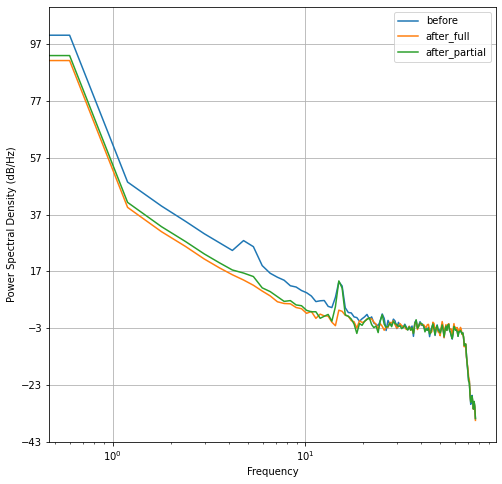

In [204]:
idx = 60
rm = 5
plt.figure(figsize=(8,8))
NUL = plt.psd(c.df_tod[c.bololist[idx]],Fs=152.59,label='before',)
#NUL = plt.psd(c.filter_df(c.df_tod)[c.bololist[idx]],Fs=152.59,label='before_ds',)
NUL = plt.psd(c.cm_subtract_full(rm)[c.bololist[idx]],Fs=152.59,label='after_full')
NUL = plt.psd(c.cm_subtract(rm)[c.bololist[idx]],Fs=152.59,label='after_partial')
plt.xscale('log')
plt.legend()

In [95]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if lowcut == 0:
        btype = 'low'
        lh = high
    elif lowcut > 0:
        btype = 'band'
        lh = [low,high]
    else:
        raise ValueError
        
    b, a = butter(order, lh, btype=btype)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [96]:
tod = c.df_tod[c.bololist[idx]]

In [113]:
todf = butter_bandpass_filter(tod,0,6,152.59,6)

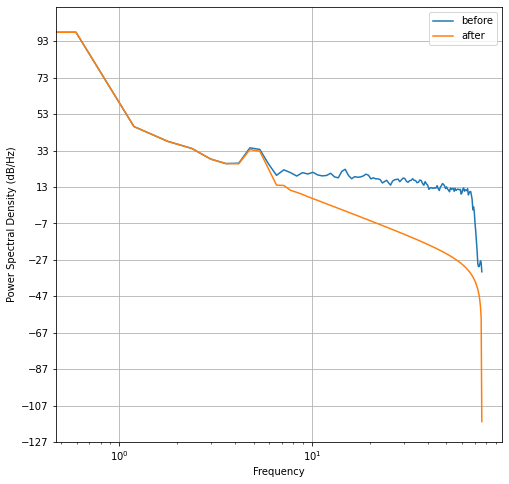

In [114]:
plt.figure(figsize=(8,8))
NUL = plt.psd(tod,Fs=152.59,label='before',)
NUL = plt.psd(todf,Fs=152.59,label='after',)
plt.xscale('log')
plt.legend()

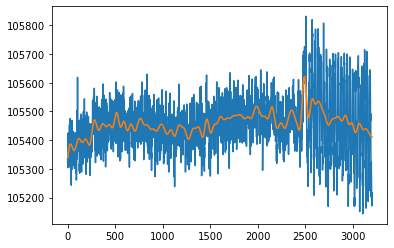

In [90]:
plt.plot(tod)
plt.plot(todf)